In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import numpy as np
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
import torch.functional as F
from io import open
import os
from PIL import Image
import pathlib
import glob
import cv2

In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np

In [ ]:
img_zip_path = '/content/drive/MyDrive/DeepLearning_Project/SingleLabel_Dataset.zip' 

In [ ]:
%cd '/content/drive/MyDrive/DeepLearning_Project'
!ls

/content/drive/.shortcut-targets-by-id/1LzJbcvmnfeSSnJMKVdJIP-tbEatBnZpO/DeepLearning_Project
 best_checkpoint.model	 others			   single_label.model
'Copy of train.csv'	 SingleLabel_Dataset
 loss.png		 SingleLabel_Dataset.zip


In [ ]:
# zip_ref = zipfile.ZipFile(img_zip_path, 'r')
# zip_ref.extractall()
# zip_ref.close()

In [ ]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


In [ ]:
#Transforms the image into the required size accordingly
transformer=transforms.Compose([
                                
                transforms.Resize((400, 400)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                transforms.ToTensor(),
])

In [ ]:
#Dataloader to iterate over the data using batches

#Path for training and testing directory
train_path='/content/drive/MyDrive/DeepLearning_Project/SingleLabel_Dataset/train'
test_path='/content/drive/MyDrive/DeepLearning_Project/SingleLabel_Dataset/valid'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=32, shuffle=True, drop_last=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

In [ ]:
#categories/ classes of the dataset
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [ ]:
len(classes)

25

In [ ]:
#defining the model using resnet50
from torchvision import models as models
import torch.nn as nn
def model(pretrained, requires_grad):
    model = models.resnet50(progress=True, pretrained=pretrained)
    # to freeze the hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # to train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    # we have 25 classes in total
    model.fc = nn.Linear(2048, 25)
    return model

In [ ]:
model_=model(pretrained=True, requires_grad=False).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
#Optmizer and loss function is crossentropy for singlelabel classification
optimizer=Adam(model_.parameters(),lr=0.0001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [ ]:
num_epochs=10

In [ ]:
#calculating the size of training and testing images used in accuracy and loss estimation
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [ ]:
print(train_count,test_count)

12138 4034


In [ ]:
#Model training and saving best model
training_loss=[]
validation_loss=[]
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model_.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model_(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    training_loss.append(train_loss)
    
    
    # Evaluation on testing dataset
    model_.eval()
    
    test_accuracy=0.0
    test_loss=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model_(images)
        test_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    test_loss=test_loss/test_count
    validation_loss.append(test_loss)
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model_.state_dict(),'single_label.model')
        best_accuracy=test_accuracy
    
       


Epoch: 0 Train Loss: tensor(2.5567) Train Accuracy: 0.2311748228703246 Test Accuracy: 0.25483391175012393
Epoch: 1 Train Loss: tensor(2.4402) Train Accuracy: 0.2609985170538804 Test Accuracy: 0.26202280614774415
Epoch: 2 Train Loss: tensor(2.3833) Train Accuracy: 0.2703905091448344 Test Accuracy: 0.25037183936539414
Epoch: 3 Train Loss: tensor(2.3500) Train Accuracy: 0.27500411929477675 Test Accuracy: 0.27119484382746656
Epoch: 4 Train Loss: tensor(2.3247) Train Accuracy: 0.27755808205635196 Test Accuracy: 0.26797223599405057
Epoch: 5 Train Loss: tensor(2.3106) Train Accuracy: 0.27953534354918436 Test Accuracy: 0.2565691621219633
Epoch: 6 Train Loss: tensor(2.3001) Train Accuracy: 0.28175976272862086 Test Accuracy: 0.26474962816063463
Epoch: 7 Train Loss: tensor(2.2864) Train Accuracy: 0.28192453451969024 Test Accuracy: 0.263262270699058
Epoch: 8 Train Loss: tensor(2.2748) Train Accuracy: 0.2862909869830285 Test Accuracy: 0.2699553792761527
Epoch: 9 Train Loss: tensor(2.2649) Train Acc

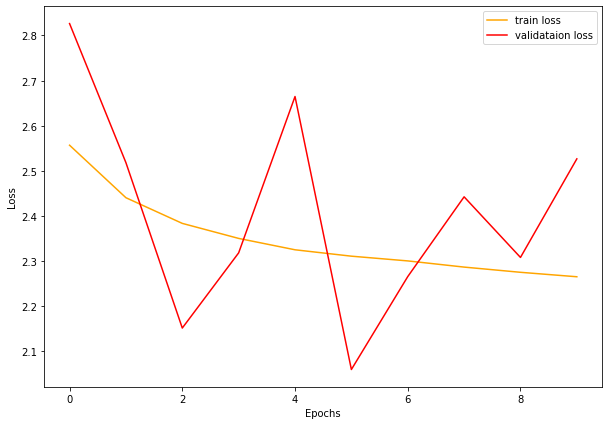

In [ ]:
# plot and save the train and validation line graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(training_loss, color='orange', label='train loss')
plt.plot(validation_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/DeepLearning_Project/loss.png')
plt.show()

In [ ]:
validation_loss

[tensor(2.8264),
 tensor(2.5180),
 tensor(2.1512),
 tensor(2.3179),
 tensor(2.6647),
 tensor(2.0592),
 tensor(2.2653),
 tensor(2.4422),
 tensor(2.3078),
 tensor(2.5264)]

In [ ]:

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [ ]:
from torchvision import models as models
import torch.nn as nn
def model2(pretrained, requires_grad):
    model = models.resnet50(progress=True, pretrained=pretrained)
    # to freeze the hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # to train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    # we have 25 classes in total
    model.fc = nn.Linear(2048, 25)
    return model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#intialize the model
model = model2(pretrained=False, requires_grad=False).to(device)
# load the model checkpoint
checkpoint = torch.load('/content/drive/MyDrive/DeepLearning_Project/single_label.model')
# load model weights state_dict
model.load_state_dict(checkpoint)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#Dataloader

#Path for training and testing directory
testing_path='/content/drive/MyDrive/DeepLearning_Project/SingleLabel_Dataset/test'

testing_loader=DataLoader(
    testing_path,
    batch_size=1, shuffle=False
)

In [ ]:
testing_loader

In [ ]:
testing_count=len(glob.glob(testing_path+'/**/*.jpg'))

In [ ]:
testing_accuracy=0.0
for i, (images,labels) in enumerate(testing_loader):
    if torch.cuda.is_available():
        images=Variable(images.cuda())
        labels=Variable(labels.cuda())
        
    outputs=model(images)
    _,prediction=torch.max(outputs.data,1)
    testing_accuracy+=int(torch.sum(prediction==labels.data))


In [ ]:
print(testing_accuracy/testing_count)

0.25656565656565655


In [ ]:
# glob.glob(testing_path+'/**/*.jpg')

In [ ]:
# for i, (images,labels) in enumerate(testing_loader):
#     if torch.cuda.is_available():
#         images=Variable(images.cuda())
#         labels=Variable(labels.cuda())
#     # print('images',images)
#     outputs=model(images)
#     # print('out',outputs)
#     # print(outputs.data)
#     _,prediction=torch.max(outputs.data,1)
#     print(labels)
#     testing_accuracy+=int(torch.sum(prediction==labels.data))
#     if(i==1):
#       break

In [ ]:
testing_loader

In [ ]:
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
def prediction(img_path,transformer):
    i1=mpimg.imread(img_path)
    
    imgplot=plt.imshow(i1)
    plt.show()
    # print(img_path)
    print('Actual --',img_path.split('/')[-2])
    image=Image.open(img_path)
    
    image_tensor=transformer(image).float()
    
    
    image_tensor=image_tensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image_tensor.cuda()
        
    input=Variable(image_tensor.cuda())
    
    
    output=model(input)
    
    index=output.cpu().data.numpy().argmax()
    
    pred=classes[index]
    # image = image
    # image = image.detach().cpu().numpy()
    # image = np.transpose(image, (1, 2, 0))
    # plt.imshow(image)
    
    return pred

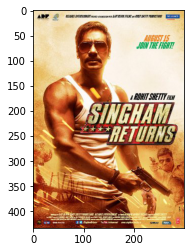

Actual -- Action
predicted Drama


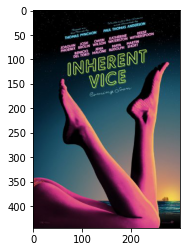

Actual -- Comedy
predicted Drama


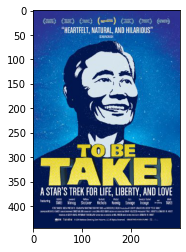

Actual -- Biography
predicted Documentary


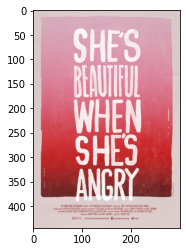

Actual -- Documentary
predicted Documentary


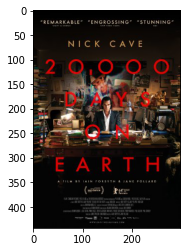

Actual -- Drama
predicted Drama


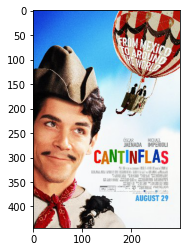

Actual -- Drama
predicted Comedy


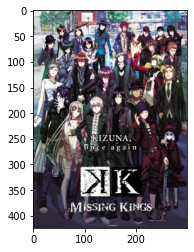

Actual -- Animation
predicted Comedy


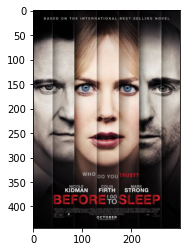

Actual -- Mystery
predicted Drama


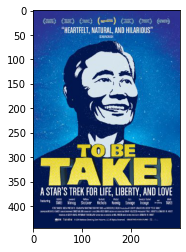

Actual -- Documentary
predicted Documentary


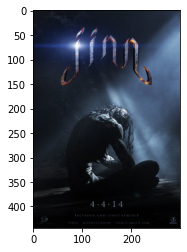

Actual -- Thriller
predicted Action


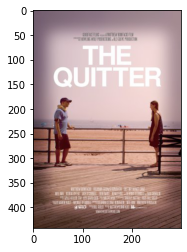

Actual -- Comedy
predicted Drama


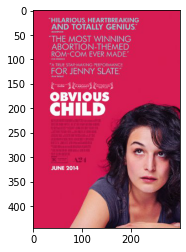

Actual -- Comedy
predicted Drama


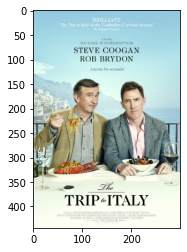

Actual -- Comedy
predicted Comedy


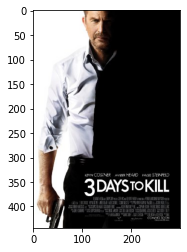

Actual -- Drama
predicted Drama


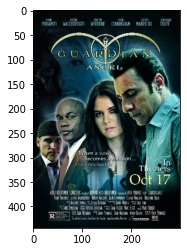

Actual -- Action
predicted Drama


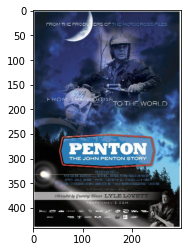

Actual -- Adventure
predicted Action


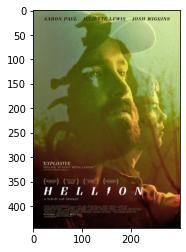

Actual -- Thriller
predicted Drama


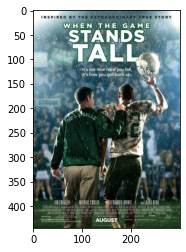

Actual -- Sport
predicted Drama


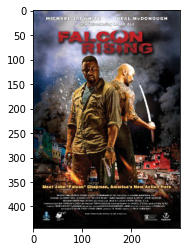

Actual -- Adventure
predicted Adventure


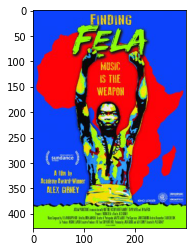

Actual -- History
predicted Comedy


In [ ]:
import random
myfiles=glob.glob(testing_path+'/**/*.jpg')
random.shuffle(myfiles)
for i in myfiles[:20]:
  print('predicted' , prediction(i,transformer=transformer))